## Importing libraries

In [1]:
# Importing necessary libraries
import os
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
import librosa

# Importing necessary libraries
import glob as glob
import cv2
import random
import os
%matplotlib inline

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, concatenate 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from sklearn.feature_extraction import texture
from sklearn.svm import SVC

from matplotlib import pyplot as plt

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.1


## Data Preparation for Voice Tone Analysis Model

In [2]:
# Data Preparation for Voice Tone Analysis Model (TESS Dataset)
audio_data_directory = "TESS/"
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

audio_features = []
audio_labels = []

# Loop through each emotion and load corresponding audio files
for emotion in emotions:
    for audio_file in os.listdir(audio_data_directory):
        if emotion in audio_file:
            audio_path = os.path.join(audio_data_directory, audio_file)
            # Load audio file and extract features using librosa
            y, sr = librosa.load(audio_path, sr=None)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs_mean = np.mean(mfccs.T, axis=0)
            audio_features.append(mfccs_mean)
            audio_labels.append(emotion)


In [3]:
# Convert features and labels to numpy arrays
audio_features = np.array(audio_features)
audio_labels = np.array(audio_labels)

In [4]:
# Encode labels
label_encoder = LabelEncoder()
audio_labels_encoded = label_encoder.fit_transform(audio_labels)
num_classes = len(label_encoder.classes_)

In [5]:
# Split the dataset into training and validation sets
audio_train, audio_validation, labels_train, labels_validation = train_test_split(
    audio_features, audio_labels_encoded, test_size=0.2, random_state=42
)

In [6]:
# Print shapes for verification
print("Training data shape:", audio_train.shape)
print("Validation data shape:", audio_validation.shape)
print("Training labels shape:", labels_train.shape)
print("Validation labels shape:", labels_validation.shape)

Training data shape: (1920, 40)
Validation data shape: (480, 40)
Training labels shape: (1920,)
Validation labels shape: (480,)


In [7]:
print("Shape of audio_train:", audio_train.shape)

Shape of audio_train: (1920, 40)


## Voice Tone Analysis Model

In [8]:
# Implement and train a separate model for voice tone analysis
def audio_model(input_shape_audio):
    inputs_audio = Input(input_shape_audio)
    # Define the architecture for voice tone analysis model branch
    # For example:
    x = Dense(128, activation='relu')(inputs_audio)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_audio_branch = Dense(32, activation='relu')(x)
    
    return inputs_audio, output_audio_branch

In [9]:
# Model Architecture for Image-based Emotion Detection with Voice Tone Analysis
def combined_model(input_shape_image, input_shape_audio, num_emotions):
    # Image branch
    inputs_image = Input(input_shape_image)
    conv_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs_image)
    # Add more convolutional and pooling layers as needed
    # Flatten and add dense layers
    
    # Audio branch
    inputs_audio, output_audio_branch = audio_model(input_shape_audio)
    
    # Combine image and audio branches
    combined_features = concatenate([conv_1, output_audio_branch])
    
    # Dense layers for final prediction
    dense_1 = Dense(256)(combined_features)
    # Add more dense layers as needed
    output = Dense(num_emotions, activation="softmax")(dense_1)
    
    model = Model(inputs=[inputs_image, inputs_audio], outputs=[output])
    
    return model

In [10]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input, Reshape

# Define the model architecture
input_audio = Input(shape=(audio_train.shape[1],))
x = Reshape((audio_train.shape[1], 1))(input_audio)  # Reshape for compatibility with Conv1D
x = Conv1D(32, kernel_size=3, activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, kernel_size=3, activation="relu")(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation="relu")(x)
output_audio = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_audio, outputs=output_audio)

## Initialize and compile the combined model

In [11]:
# Compile the model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy

# Compile the model
model.compile(
    loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=[Accuracy()]
)

In [12]:
# Display the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 reshape (Reshape)           (None, 40, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 38, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                         

## Training the Combined Model

In [13]:
epochs = 15
#steps_per_epoch = train_generator.n // train_generator.batch_size
#validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weightsVTA.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]

In [14]:
batch_size = 32

# Train the model
history = model.fit(
    audio_train,
    to_categorical(labels_train, num_classes=num_classes),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        audio_validation,
        to_categorical(labels_validation, num_classes=num_classes),
    ),
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/15
59/60 [============================>.] - ETA: 0s - loss: 0.9723 - accuracy: 0.0000e+00
Epoch 1: saving model to model_weightsVTA.h5
60/60 [==============================] - 6s 28ms/step - loss: 0.9620 - accuracy: 0.0000e+00 - val_loss: 0.2902 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/15
57/60 [===========================>..] - ETA: 0s - loss: 0.1859 - accuracy: 0.0000e+00
Epoch 2: saving model to model_weightsVTA.h5
60/60 [==============================] - 1s 9ms/step - loss: 0.1859 - accuracy: 0.0000e+00 - val_loss: 0.0933 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/15
59/60 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.0000e+00
Epoch 3: saving model to model_weightsVTA.h5
60/60 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.0000e+00 - val_loss: 0.0675 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/15
55/60 [==========================>...] - ETA: 0s - loss: 0.0429 - accuracy: 0.0000e+00
Epoch 4: saving model 

## Model Evaluation

In [15]:
# Evaluate the model
evaluation = model.evaluate(
    audio_validation,
    to_categorical(labels_validation, num_classes=num_classes),
    batch_size=batch_size
)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

15/15 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.0031
Validation Loss: 0.005927962251007557
Validation Accuracy: 0.0031250000465661287


## Plotting Loss

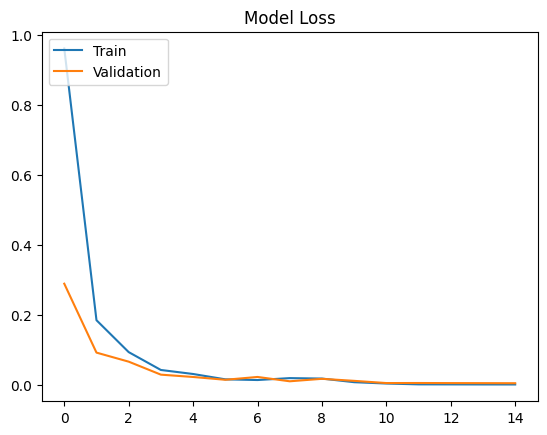

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

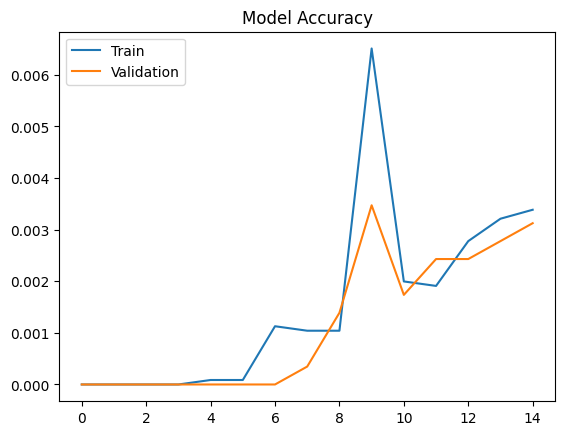

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Saving the Model

In [18]:
model_json = model.to_json()
with open("model_aVTN.json", "w") as json_file:
    json_file.write(model_json)